In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Nạp dữ liệu

In [2]:
df = pd.read_csv('a10.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


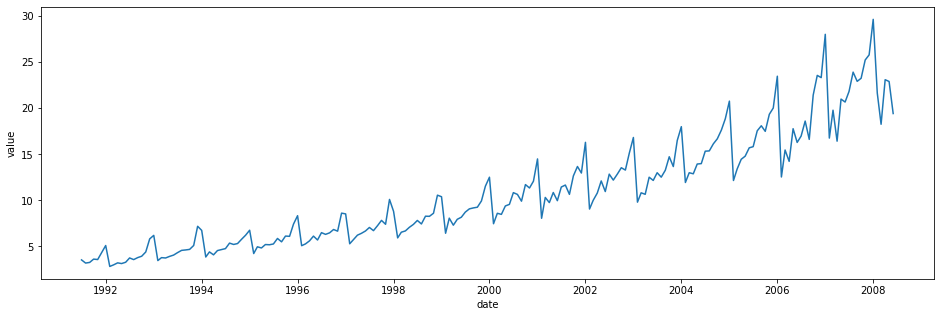

In [3]:
plt.figure(figsize=(16, 5))
sns.lineplot(data=df, x='date', y='value')
plt.show()

# SARIMA

## Giải thích mô hình SARIMA

## Xây dựng mô hình SARIMA

Do dữ liệu có tính seasonal với chu kỳ là 12, ta khử đi tính seasonal bằng cách lấy difference với lag bằng 12 tháng.

In [154]:
df['seasonal_removed'] = df['value'].diff(12)

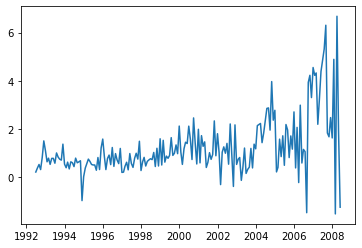

In [156]:
plt.plot(df['seasonal_removed'])
plt.show()

In [204]:
df['seasonal_removed_diff1'] = df['seasonal_removed'].diff()

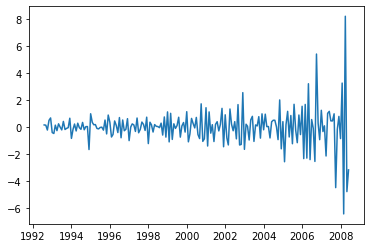

In [205]:
plt.plot(df['seasonal_removed_diff1']);

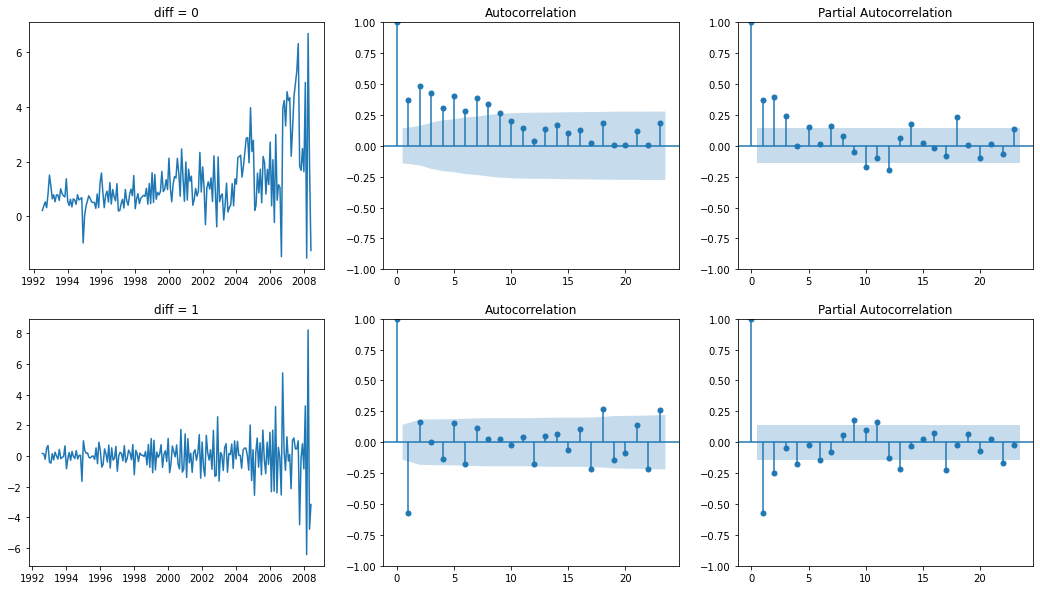

In [211]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Diff 0
diff0_axes = axes[0]
diff0_axes[0].plot(df['seasonal_removed'])
plot_acf(df['seasonal_removed'].dropna(), ax=diff0_axes[1])
plot_pacf(df['seasonal_removed'].dropna(), ax=diff0_axes[2], method='ywm')

diff0_axes[0].set_title('diff = 0')

# Diff 1
diff1_axes = axes[1]
diff1_axes[0].plot(df['seasonal_removed_diff1'])
plot_acf(df['seasonal_removed_diff1'].dropna(), ax=diff1_axes[1])
plot_pacf(df['seasonal_removed_diff1'].dropna(), ax=diff1_axes[2], method='ywm')

diff1_axes[0].set_title('diff = 1')

plt.show()

### Xây dựng mô hình

In [212]:
train_end = dt.datetime(2007, 1, 1)
test_end = dt.datetime(2008, 1, 1)

train = df[:train_end]['value'].copy()
test = df[train_end + dt.timedelta(days=1):test_end]['value'].copy()

In [217]:
order = (3, 1, 3)
seasonal_order = (1, 1, 0, 12)
model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)

/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mdnam/.local/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [214]:
%%time
model_sarima_fitted = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04119D+00    |proj g|=  1.02254D-01

At iterate    5    f=  1.03644D+00    |proj g|=  8.91940D-03


 This problem is unconstrained.



At iterate   10    f=  1.03594D+00    |proj g|=  1.07213D-03

At iterate   15    f=  1.03588D+00    |proj g|=  2.83737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     23      1     0     0   6.437D-06   1.036D+00
  F =   1.0358572422097210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
CPU times: user 912 ms, sys: 13 ms, total: 925 ms
Wall time: 681 ms


### Đánh giá

In [215]:
print(model_sarima_fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  187
Model:             SARIMAX(3, 1, 2)x(1, 1, [], 12)   Log Likelihood                -193.705
Date:                             Mon, 09 May 2022   AIC                            401.411
Time:                                     17:59:16   BIC                            423.524
Sample:                                 07-01-1991   HQIC                           410.381
                                      - 01-01-2007                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5727      0.162     -3.531      0.000      -0.891      -0.255
ar.L2          0.3545      

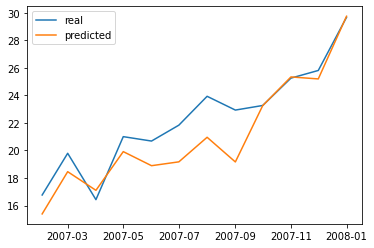

In [216]:
plt.plot(test)
plt.plot(model_sarima_fitted.forecast(len(test)))
plt.legend(['real', 'predicted'])
plt.show()

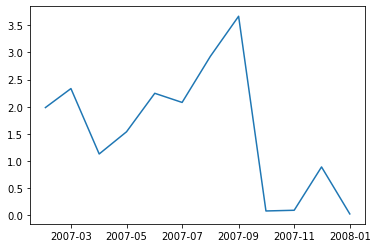

In [203]:
plt.plot(np.abs(test - model_sarima_fitted.forecast(len(test))))
plt.show()

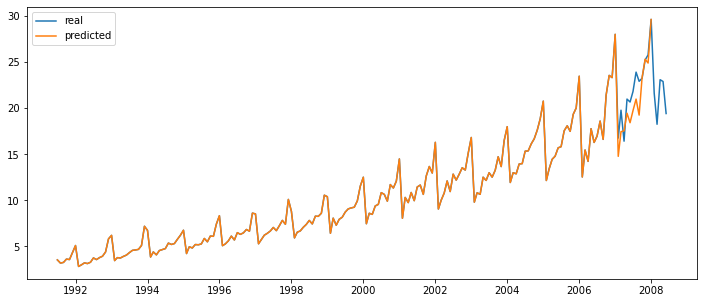

In [202]:
plt.figure(figsize=(12, 5))
plt.plot(df['value'])
plt.plot(pd.concat([df.loc[:train_end]['value'], model_sarima_fitted.forecast(len(test))]))
plt.legend(['real', 'predicted'])
plt.show()

## Dự báo

TODO: Fit mô hình trên toàn bộ dữ liệu và dự đoán cho một năm sau